# SPAN Benchmarks H3K27me3

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
from itertools import product


In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


# Hg38 load peaks

In [3]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
# GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GM12878, H1, HepG2 and HMEC are of bad quality
GSE26320_CELLS = ['HSMM', 'K562', 'NHEK', 'NHLF', 'Huvec']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K27me3', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27me3']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [5]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 10


,file,modification,cell,replicate,fdr,peaks,avlength,tool
0,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27me3,Huvec,rep2,0.1,14733,709.756940,MACS2 broad
1,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27me3,NHLF,rep1,0.05,36771,10775.558864,SPAN
7,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27me3,Huvec,rep1,0.05,37653,4083.519056,SPAN
8,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27me3,Huvec,rep2,0.01,40452,6814.618511,SICER
6,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27me3,HSMM,rep1,0.01,25434,6606.163639,SICER


In [6]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number

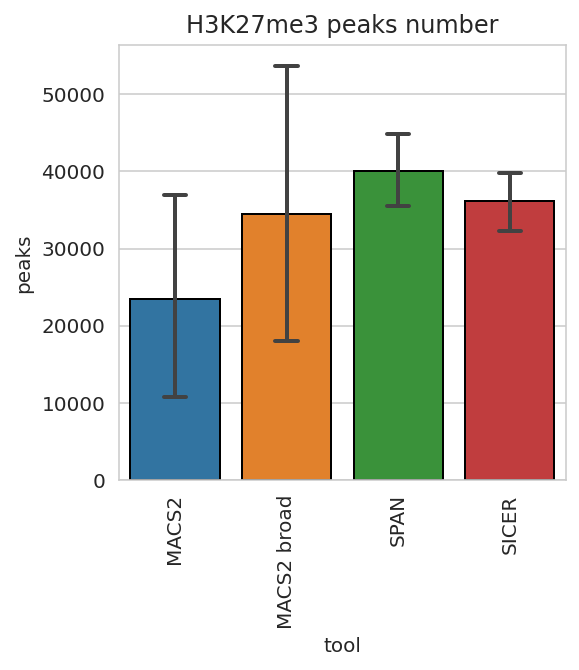

In [7]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=TOOLS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27me3 peaks number')
plt.show()

In [8]:
print('Load lengths')
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,tool,length
265052,SPAN,1239
321281,SPAN,4609
326424,SPAN,1461
222590,SICER,9399
151261,MACS2 broad,718
73289,MACS2,387
98927,MACS2 broad,566
225688,SICER,4599
265996,SPAN,9079
82722,MACS2 broad,366


In [9]:
# plt.figure(figsize=(4, 4))
# ax = plt.axes()
# g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax, order=TOOLS, showfliers=False)
# ax.title.set_text('H3K27me3 peaks length')
# ax.xaxis.set_tick_params(rotation=90)
# ax.set_ylim([0, 15_000])
# plt.show()

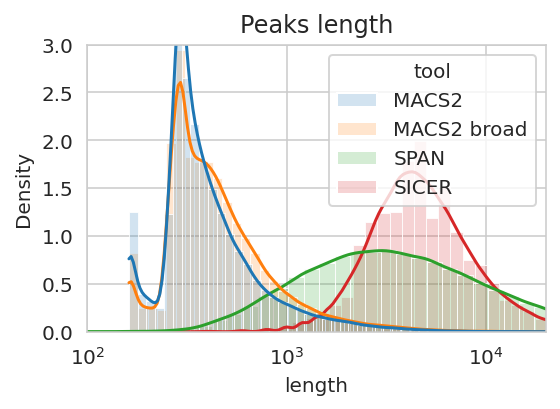

In [10]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=TOOLS)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
# # Randomly tweak SPAN, SICER lengths for visualization purposes
# tspan = t['tool'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))
# tsicer = t['tool'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

In [12]:
# plt.figure(figsize=(8, 5))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
# ax.title.set_text('H3K27me3 peaks length')
# plt.show()

In [13]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(10)

0it [00:00, ?it/s]

,tool,coverage
7,MACS2,144678
22,SICER,230852902
28,SICER,275664948
29,SICER,231093987
4,MACS2,1696548
38,SPAN,503178834
0,MACS2,2972003
39,SPAN,122850266
14,MACS2 broad,54519904
34,SPAN,325924653


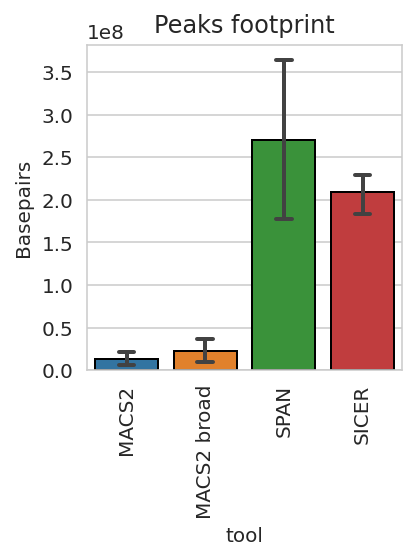

In [14]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Consistency analysis between replicates

In [15]:
reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                if len(t1) != 1 or len(t2) != 1:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(5)

0it [00:00, ?it/s]

HSMM H3K27me3
K562 H3K27me3
NHEK H3K27me3
NHLF H3K27me3
Huvec H3K27me3


,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len
2,H3K27me3,HSMM,SICER,rep1,rep2,25434,168021166,37162,222683238,20694,112616060,21316,112616060
6,H3K27me3,K562,SICER,rep1,rep2,32283,239874317,47375,213219825,23178,121341160,29641,121341160
13,H3K27me3,NHLF,MACS2 broad,rep1,rep2,513,242914,90245,59958992,487,224839,359,224839
1,H3K27me3,HSMM,MACS2 broad,rep1,rep2,9029,3474118,4064,1954536,1318,404539,1300,404539
9,H3K27me3,NHEK,MACS2 broad,rep1,rep2,71383,54519904,58290,37525393,24943,20753507,28071,20753507


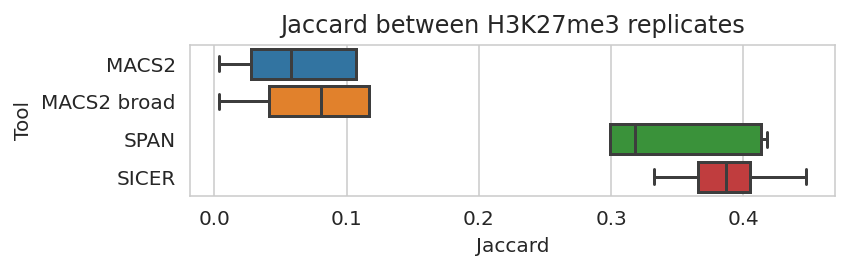

In [16]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))
g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard', palette=TOOLS_PALETTE, order=TOOLS,
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K27me3 replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
sorted(df_fdr_peaks[df_fdr_peaks['tool'] == 'SPAN']['file'])

['/home/jetbrains/data/2023_GSE26320/span/GSM646396_HSMM_H3K27me3_rep1_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646397_HSMM_H3K27me3_rep2_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646416_Huvec_H3K27me3_rep1_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646417_Huvec_H3K27me3_rep2_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646436_K562_H3K27me3_rep1_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646437_K562_H3K27me3_rep2_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646458_NHEK_H3K27me3_rep1_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646459_NHEK_H3K27me3_rep2_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646478_NHLF_H3K27me3_rep1_100_0.05_3.peak',
 '/home/jetbrains/data/2023_GSE26320/span/GSM646479_NHLF_H3K27me3_rep2_100_0.05_3.peak']

In [18]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]
reps_overlap.sample(5)

,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len,jaccard,peak1_overlap_fraction,peak2_overlap_fraction,peak1_overlap_fraction_len,peak2_overlap_fraction_len
18,H3K27me3,Huvec,SICER,rep1,rep2,36613,231093987,40452,275664948,26221,141354792,25477,141354792,0.386845,0.716166,0.629808,0.611677,0.512778
0,H3K27me3,HSMM,MACS2,rep1,rep2,5126,1696548,2485,994243,584,147728,567,147728,0.058091,0.113929,0.228169,0.087076,0.148583
10,H3K27me3,NHEK,SICER,rep1,rep2,37724,199969276,37837,184272963,26041,118765641,26970,118765641,0.447368,0.690303,0.712794,0.593919,0.644509
9,H3K27me3,NHEK,MACS2 broad,rep1,rep2,71383,54519904,58290,37525393,24943,20753507,28071,20753507,0.291107,0.349425,0.481575,0.380659,0.553052
15,H3K27me3,NHLF,SPAN,rep1,rep2,36771,396228075,45253,234562224,21867,185903040,34679,185903040,0.417866,0.594681,0.766336,0.469182,0.792553


In [19]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

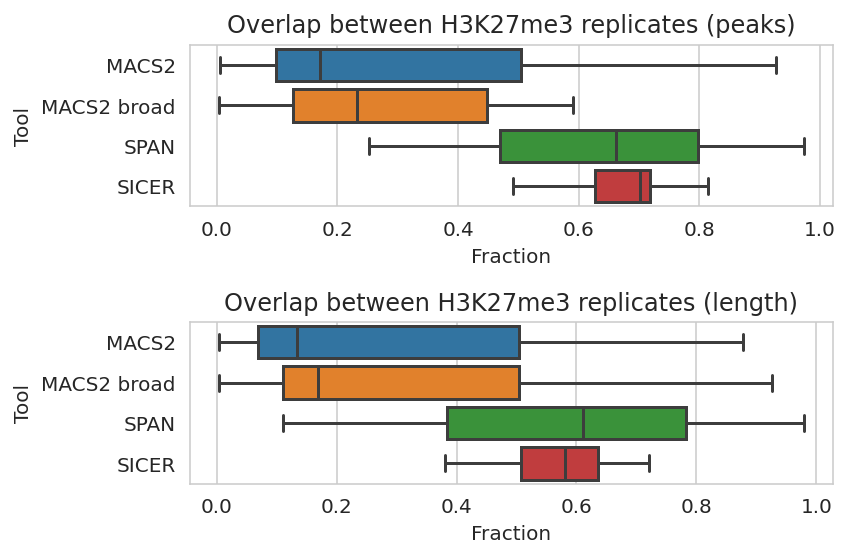

In [20]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0], palette=TOOLS_PALETTE,
                       order=TOOLS, showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K27me3 replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1], palette=TOOLS_PALETTE,
                       order=TOOLS, showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K27me3 replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

## Analyze peaks and diffs

In [21]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'peaks'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        bench_df.loc[len(bench_df)] = (c, r, tool, peaks)
# bench_df

0it [00:00, ?it/s]

HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
Huvec rep1
Huvec rep2


In [22]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K27me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (c, r, name, peaks)

# display(diff_bench_df.head())

0it [00:00, ?it/s]

HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
Huvec rep1
Huvec rep2


In [23]:
full_bench_df = pd.concat([
    bench_df[['cell', 'replicate', 'name', 'peaks']],
    diff_bench_df[['cell', 'replicate', 'name', 'peaks']]]).reset_index(drop=True)
full_bench_df.sample(10)

,cell,replicate,name,peaks
4,HSMM,rep2,MACS2,2485
51,HSMM,rep2,SICER - SPAN,68
26,NHLF,rep1,MACS2 broad,513
10,K562,rep1,MACS2 broad,18090
44,HSMM,rep1,SPAN - SICER,3722
15,K562,rep2,SICER,47375
23,NHEK,rep2,SICER,37837
12,K562,rep2,MACS2,13503
49,HSMM,rep2,MACS2 broad - SPAN,0
32,Huvec,rep1,MACS2,50679


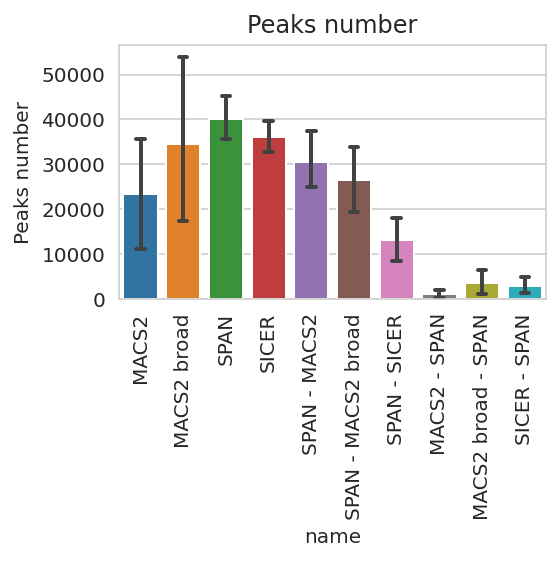

In [24]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Save benchmark df

In [25]:
full_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K27me3_full_bench_df.csv.gz', index=False, compression='gzip')

# Functional annotation

In [26]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

! rm -r {GSE26320_PATH_HG38}/summary_H3K27me3
! mkdir -p {GSE26320_PATH_HG38}/summary_H3K27me3

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{GSE26320_PATH_HG38}/summary_H3K27me3/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            ! cat {tf} >> "{GSE26320_PATH_HG38}/summary_H3K27me3/{filename}.bed_"

for f in os.listdir(GSE26320_PATH_HG38 + '/summary_H3K27me3'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{GSE26320_PATH_HG38}/summary_H3K27me3/{f}" | cut -f1-3> "{GSE26320_PATH_HG38}/summary_H3K27me3/{f_sorted}"
    ! rm "{GSE26320_PATH_HG38}/summary_H3K27me3/{f}"

0it [00:00, ?it/s]

HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
Huvec rep1
Huvec rep2


# Coverage

In [7]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [8]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27me3')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64641...,H3K27me3,Huvec,rep2
7,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,H3K27me3,NHEK,rep1
9,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,H3K27me3,K562,rep2


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64649...,Input,NHLF,rep1
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep1
7,/home/jetbrains/data/2023_GSE26320/bw/GSM64647...,Input,NHEK,rep2


In [9]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [10]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27me3') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

HSMM rep1
SPAN /tmp/tmpqba8th71 /home/jetbrains/data/2023_GSE26320/bw/GSM646396_HSMM_H3K27me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646410_HSMM_Input_rep1.bw
MACS2 /tmp/tmp2a3lak80 /home/jetbrains/data/2023_GSE26320/bw/GSM646396_HSMM_H3K27me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646410_HSMM_Input_rep1.bw
SICER /tmp/tmpufvddyjj /home/jetbrains/data/2023_GSE26320/bw/GSM646396_HSMM_H3K27me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646410_HSMM_Input_rep1.bw
MACS2 broad /tmp/tmp1dc83_bc /home/jetbrains/data/2023_GSE26320/bw/GSM646396_HSMM_H3K27me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646410_HSMM_Input_rep1.bw
HSMM rep2
SPAN /tmp/tmpmfwqx4dr /home/jetbrains/data/2023_GSE26320/bw/GSM646397_HSMM_H3K27me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646411_HSMM_Input_rep2.bw
MACS2 /tmp/tmp3lxqb8tt /home/jetbrains/data/2023_GSE26320/bw/GSM646397_HSMM_H3K27me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646411_HSMM_Input_rep2.bw
SICER /tmp/tmp9q

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,HSMM,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,SPAN,/tmp/tmpqba8th71,23986,60980845,6.633039e+06,7.657034e+07,2.398575e+06,8.294788e+07
1,HSMM,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,MACS2,/tmp/tmp2a3lak80,5126,1696548,4.149101e+05,7.656632e+07,3.650953e+04,8.294788e+07
2,HSMM,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,SICER,/tmp/tmpufvddyjj,25434,168021166,1.407761e+07,7.655827e+07,6.190866e+06,8.294788e+07
3,HSMM,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,MACS2 broad,/tmp/tmp1dc83_bc,9029,3474118,7.733587e+05,7.656632e+07,8.341136e+04,8.294788e+07
4,HSMM,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,SPAN,/tmp/tmpmfwqx4dr,43037,537439525,4.270195e+07,8.197982e+07,1.172843e+07,5.883863e+07
5,HSMM,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,MACS2,/tmp/tmp3lxqb8tt,2485,994243,4.412863e+05,8.180714e+07,7.661429e+03,5.859942e+07
6,HSMM,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,SICER,/tmp/tmp9q7ro6de,37162,222683238,2.502892e+07,8.192874e+07,5.063042e+06,5.872033e+07
7,HSMM,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,MACS2 broad,/tmp/tmp8fjbsa77,4064,1954536,7.969024e+05,8.180714e+07,2.721536e+04,5.859942e+07
8,K562,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,SPAN,/tmp/tmpaw21c_3n,39605,177282396,2.202150e+07,9.504821e+07,8.088194e+06,9.641159e+07
9,K562,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,MACS2,/tmp/tmpkcih0z2a,9953,3897646,1.172451e+06,9.503519e+07,1.245423e+05,9.641159e+07


In [11]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

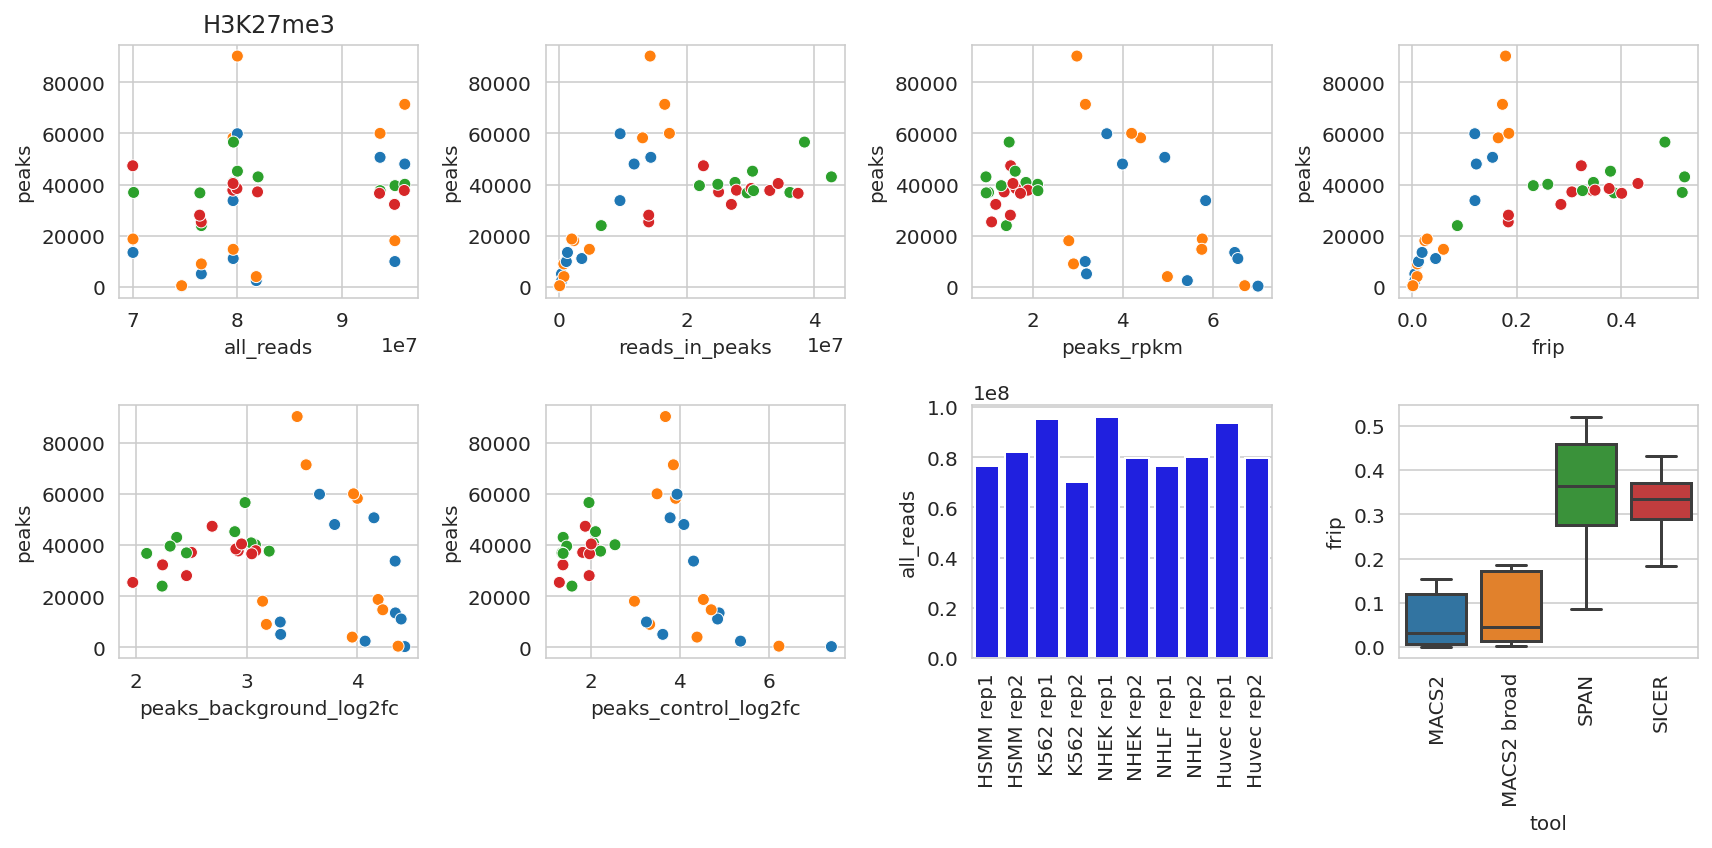

In [12]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'] + ' ' + tt['replicate'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
frip_df.to_csv(f'{GSE26320_PATH_HG38}/pics/H3K27me3_frip.csv.gz', index=None, compression='gzip')

## Peaks Density

In [13]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K27me3') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
Huvec rep1
Huvec rep2


,modification,cell,replicate,name,position,length,type,coverage,total_coverage
1381120,H3K27me3,NHEK,rep1,SICER,chr12:111266200-111275999,9799,treatment,1572.649026,9.593442e+07
2668622,H3K27me3,NHLF,rep1,SPAN - SICER,chr22:22889950-22893063,3113,control,119.298706,7.896369e+07
4135554,H3K27me3,Huvec,rep2,SPAN - MACS2 broad,chr9:18055175-18059576,4401,treatment,420.365552,7.959440e+07
1741418,H3K27me3,NHEK,rep1,MACS2 broad,chr3:42850597-42851292,695,control,23.843991,9.822395e+07
2505194,H3K27me3,NHLF,rep1,SPAN - MACS2,chr2:20881003-20888275,7272,treatment,322.067500,7.640456e+07


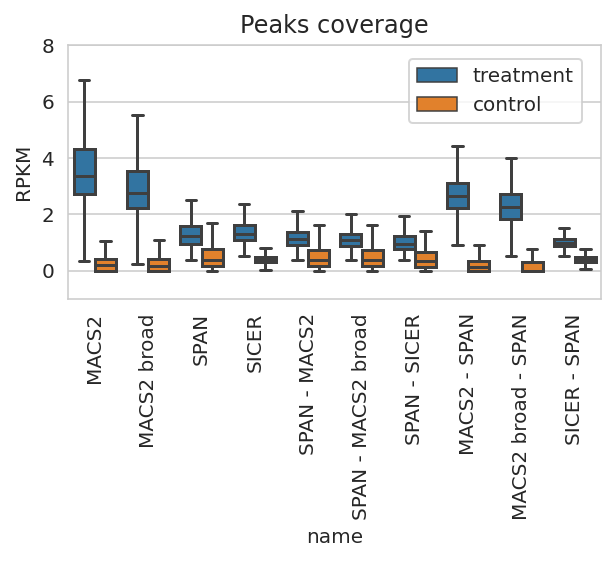

In [14]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 8)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [35]:
CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH_HG38 + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH_HG38 + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH_HG38 + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH_HG38 + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}
CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
GM12878
H1
HepG2
K562
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [36]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, r, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, r, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
Huvec rep1
Huvec rep2


,cell,replicate,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,K562,rep1,MACS2,9953,35,62,635,2,1,75,...,6783,3798,28,565,39,5,10,206,170,0
1,K562,rep1,SPAN,39605,796,853,3157,64,20,2203,...,19140,16997,209,2342,682,189,278,1880,1818,0
2,K562,rep1,MACS2 broad,18090,84,129,1046,6,3,180,...,12119,7342,41,891,83,12,27,371,309,0
3,K562,rep1,SICER,32283,1026,1013,3395,79,21,2995,...,16935,16017,295,2730,1035,280,535,2073,2040,0
4,K562,rep1,SPAN - MACS2,33273,541,581,1866,39,5,1624,...,14445,12781,136,1384,448,131,171,1490,1434,0
5,K562,rep1,MACS2 - SPAN,455,0,1,10,0,0,3,...,186,129,0,15,1,0,0,8,8,0
6,K562,rep1,SPAN - MACS2 broad,29280,413,462,1355,33,4,1315,...,11915,10512,110,1046,346,104,128,1281,1229,0
7,K562,rep1,MACS2 broad - SPAN,954,2,5,25,0,0,5,...,372,268,0,28,2,0,0,16,16,0
8,K562,rep1,SPAN - SICER,8704,79,104,189,8,1,240,...,2536,2137,27,218,74,21,25,330,308,0
9,K562,rep1,SICER - SPAN,3867,66,84,124,4,0,213,...,1200,1142,19,157,81,21,32,196,193,0


In [37]:
chromhmm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_df_mean = chromhmm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]]
chromhmm_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,72.0,58.5,1128.5,13.0,5.5,142.5,42.0,1834.0,8238.0,3932.0,22.5,666.0,52.5,6.0,26.5,225.5,166.5,0.0
MACS2 broad,127.0,105.5,1553.5,17.5,7.5,254.0,78.0,3410.0,12848.0,6725.0,33.0,938.5,95.0,13.5,47.5,377.5,287.0,0.0
SPAN,2252.5,1550.5,3367.5,370.5,212.5,4795.0,2268.5,25501.0,15496.5,14161.0,1286.0,3189.5,2547.0,894.5,1809.5,3767.0,3595.0,0.0
SICER,1722.5,1221.5,4080.5,165.5,91.5,4390.5,1504.5,20739.5,21465.5,19943.5,552.5,3169.0,1542.5,452.5,1008.0,3065.5,2975.5,0.0
SPAN - MACS2,1541.5,1011.0,1713.5,279.5,171.5,3406.5,1683.5,22411.0,11050.0,9993.0,955.5,1852.5,1827.5,618.5,1305.5,2831.5,2666.5,0.0
SPAN - MACS2 broad,1398.5,897.5,1339.0,267.5,166.0,3071.5,1535.5,20989.0,9367.0,8450.5,900.5,1551.5,1680.0,572.0,1218.5,2616.5,2454.5,0.0
SPAN - SICER,652.5,328.5,280.0,155.5,99.5,1243.0,573.0,9726.5,2253.0,1939.0,463.0,460.5,788.0,259.0,622.0,1223.0,1105.0,0.0
MACS2 - SPAN,0.5,0.5,5.0,0.0,0.5,2.0,1.0,125.5,93.5,65.0,0.0,9.5,1.0,0.0,0.5,4.5,4.5,0.0
MACS2 broad - SPAN,1.5,2.5,12.5,0.0,0.5,3.0,6.0,267.0,187.0,135.0,0.0,16.0,1.5,0.0,0.5,9.5,9.5,0.0


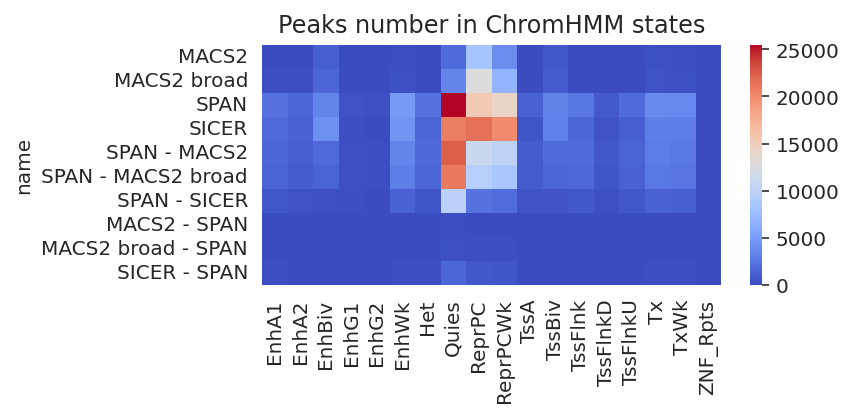

In [38]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [39]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,0.005794,0.005151,0.091961,0.000989,0.000421,0.011544,0.003586,0.165195,0.699672,0.341356,0.002036,0.056784,0.004403,0.000510,0.002095,0.019421,0.014576,0.0
MACS2 broad,0.006852,0.005751,0.083836,0.000939,0.000403,0.013716,0.004245,0.186277,0.696786,0.365706,0.001799,0.050903,0.005146,0.000731,0.002558,0.020488,0.015603,0.0
SPAN,0.060229,0.041183,0.088264,0.009967,0.005732,0.127753,0.060377,0.669885,0.401998,0.367800,0.034608,0.084185,0.068301,0.024033,0.048711,0.100229,0.095631,0.0
SICER,0.041421,0.030782,0.102883,0.003883,0.002035,0.107453,0.039459,0.532791,0.536654,0.499998,0.013118,0.080361,0.037666,0.010933,0.023917,0.074935,0.072873,0.0
SPAN - MACS2,0.048083,0.031379,0.052576,0.008759,0.005388,0.105961,0.052288,0.690845,0.337384,0.305306,0.029942,0.057278,0.057138,0.019352,0.040920,0.087979,0.082831,0.0
SPAN - MACS2 broad,0.046129,0.029739,0.044824,0.008792,0.005445,0.101593,0.050893,0.700354,0.315239,0.284232,0.029596,0.051579,0.055312,0.018823,0.040033,0.086653,0.081307,0.0
SPAN - SICER,0.039823,0.021890,0.021535,0.009180,0.005756,0.078427,0.039919,0.728038,0.202377,0.172866,0.027424,0.032756,0.047479,0.015510,0.036519,0.079856,0.072433,0.0
MACS2 - SPAN,0.027778,0.001099,0.010989,0.000000,0.027778,0.031074,0.002198,0.435897,0.232173,0.169536,0.000000,0.127595,0.028877,0.000000,0.027778,0.036569,0.036569,0.0
MACS2 broad - SPAN,0.021048,0.002621,0.013103,0.000000,0.020000,0.022621,0.006289,0.474633,0.234969,0.180461,0.000000,0.094675,0.021048,0.000000,0.020000,0.068386,0.068386,0.0


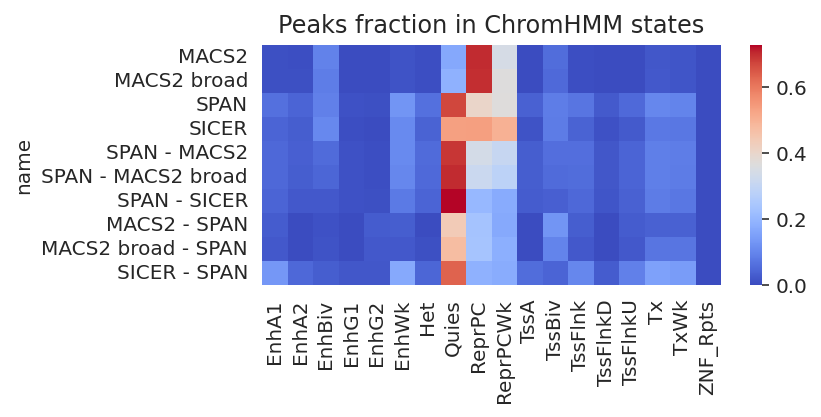

In [40]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()